# Load libraries and data

In [30]:
library(phyloseq); packageVersion("phyloseq")
library(dada2)
library(ggplot2); packageVersion("ggplot2")
library(tidyr)
library(dplyr)
library(vegan); packageVersion("vegan")
library(scales)
library(repr)
library(reshape2)
library(genefilter)
#library(VennDiagram)
#library(svglite)
#library(gridExtra)
library(DESeq2); packageVersion("DESeq2")

options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

#colorblind color vector for taxonomy plots
colors <- c("#89C5DA", "#DA5724", "#74D944", "#CE50CA", "#3F4921", "#C0717C", "#CBD588", "#5F7FC7", 
            "#673770", "#D3D93E", "#38333E", "#508578", "#D7C1B1", "#689030", "#AD6F3B", "#CD9BCD", 
            "#D14285", "#6DDE88", "#652926", "#7FDCC0", "#C84248", "#8569D5", "#5E738F", "#D1A33D", 
            "#8A7C64", "#599861", "orange", "666666", "gray80", "#FFCC00")

set.seed(100)

[1] ‘1.28.0’

[1] ‘3.2.1’


Attaching package: ‘tidyr’

The following object is masked from ‘package:S4Vectors’:

    expand


Attaching package: ‘dplyr’

The following object is masked from ‘package:matrixStats’:

    count

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union

The following object is masked from ‘package:GenomeInfoDb’:

    intersect

The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union

The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: permute
Loading required package: l

[1] ‘2.5.6’


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths


Attaching package: ‘genefilter’

The following objects are masked from ‘package:matrixStats’:

    rowSds, rowVars



[1] ‘1.24.0’

In [33]:
taxa <- readRDS('~/data/awtp2_16S/tax_final.rds')
seqtab.nochim <- readRDS('~/data/awtp2_16S/seqtab_final.rds')

# Make a data.frame holding the sample data where rownames are sampleIDs and headers are metadata parameters
metadata <- read.table('~/data/awtp2_16S/metadata.tsv', 
                       header=TRUE, row.names = 1, sep="\t")

In [35]:
location_levels = c(
    'Karina',
    'positive_control',
    'field_blank',
    'RO_BF_control',
    'negative_control',
    'WW_2ndary',
    'BAC',
    'MF_combined',
    'MF_tank',
    'RO_BF_retentate_scrapings',
    'RO_BF_separator',
    'RO_combined',
    'RO_3stage', 'RO_2stage', #'RO',
    'Loop_DPWF_inf', 'Loop_MWTP_inf', 'Loop_1', 'Loop_2', 'Loop_3', 'Loop_4', 'Loop_5',
    'DWDS_328', 'DWDS_286', 'DWDS_282B')

In [36]:
metadata$id <- row.names(metadata)
#metadata$combined_name <- paste(metadata$Description, metadata$Day, sep="_")
#metadata$longer_name <- paste(metadata$Location, metadata$combined_name, sep="_")

#unique(metadata$Location) #to show all locations, then set factor levels so they are ordered along treatment train
metadata$location_code <- factor(metadata$location_code, 
                            levels=location_levels)


In [52]:
# Construct phyloseq object from dada2 outputs and metadata table
ps <- phyloseq(otu_table(seqtab.nochim, taxa_are_rows=FALSE), 
               sample_data(metadata), 
               tax_table(taxa))

#export the sequences to fasta for other analyses
uniquesToFasta(seqtab.nochim, "~/data/awtp2_16S/all_seqs.fasta")

# remove samples that aren't part of the project
ps <- subset_samples(ps, subset = !(project_type %in% c('Karina', 'ECAWPC')))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7521 taxa and 180 samples ]
sample_data() Sample Data:       [ 180 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 7521 taxa by 6 taxonomic ranks ]

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


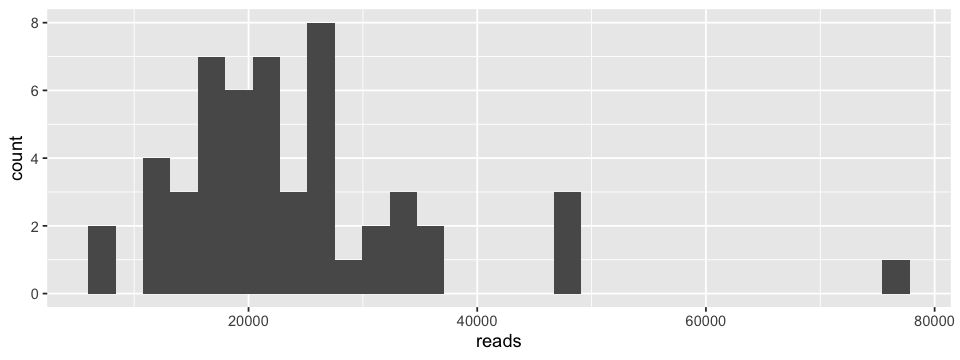

In [80]:
read_counts <- as.data.frame(rowSums(otu_table(ps_dpwf_blank)))
colnames(read_counts) <- c('reads')

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot(read_counts, aes(x=reads))+
    geom_histogram()

In [ ]:
#remove samples with too few reads
ps <- prune_samples(sample_sums(ps)>=1000, ps) #remove failed samples
ps

# Data exploration

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”

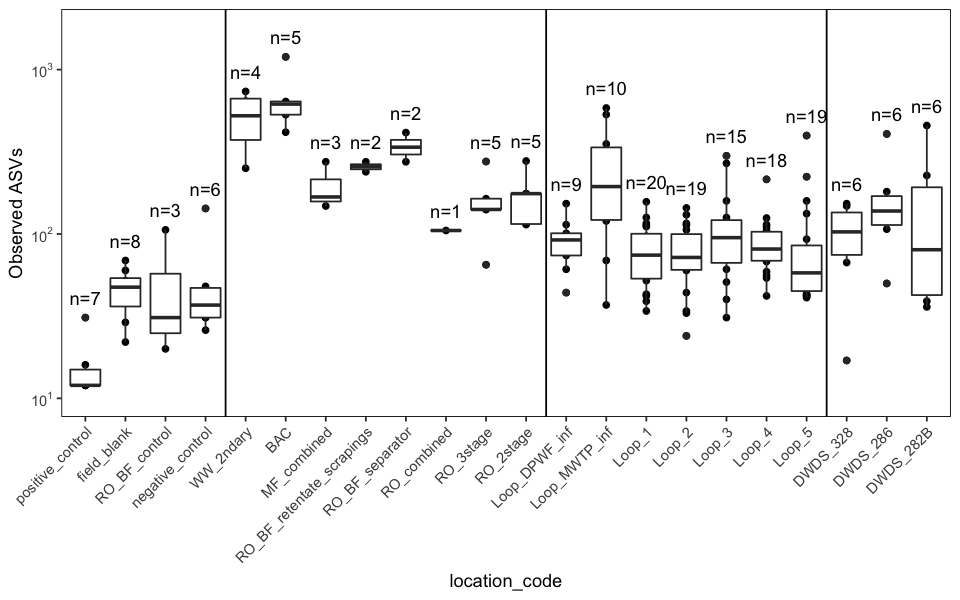

In [53]:
n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}
#ps_bulk_sig <- subset_samples(ps_bulk_blank_sig, subset = Type %in% "Bulk")
options(repr.plot.width = 8, repr.plot.height = 5)
plot_richness(ps, x="location_code", measures=c("Observed"))+
    geom_boxplot()+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
     strip.background = element_blank(), 
     strip.text.x = element_blank(),
     #axis.title.x = element_blank(),
     axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    ylab("Observed ASVs") +
    scale_y_continuous(trans="log10", limits=c(10,1800), labels=trans_format("log10", math_format(10^.x)))+
    stat_summary(fun.data = n_fun, geom = "text", vjust=-1)+
    geom_vline(xintercept=4.5, linetype='solid')+
    geom_vline(xintercept=12.5, linetype='solid')+
    geom_vline(xintercept=19.5, linetype='solid')

#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/asv_observed_boxplot.svg", device="svg", width=3.5, height=2.75)

In [63]:
# select only samples of interest
ps_dpwf <- subset_samples(ps, subset = project_type %in% c("DPWF", "Experimental"))
ps_blank <- subset_samples(ps, subset = location_code %in% c("negative_control", "field_blank"))

# merge bulk and blank samples back together and filter for only taxa that occur in at least one sample
ps_dpwf_blank <- merge_phyloseq(ps_dpwf, ps_blank)

# normalize to percents
ps_dpwf_blank_perc <- transform_sample_counts(ps_dpwf_blank, function(OTU) 100*OTU/sum(OTU))
ps_dpwf_blank_perc_filt2 <- filter_taxa(ps_dpwf_blank_perc, filterfun(kOverA(2, 2.5)), TRUE) #one sample, 2 perc.
ps_dpwf_blank_perc_filt1 <- filter_taxa(ps_dpwf_blank_perc, filterfun(kOverA(2, 1)), TRUE) #one sample, 2 perc.


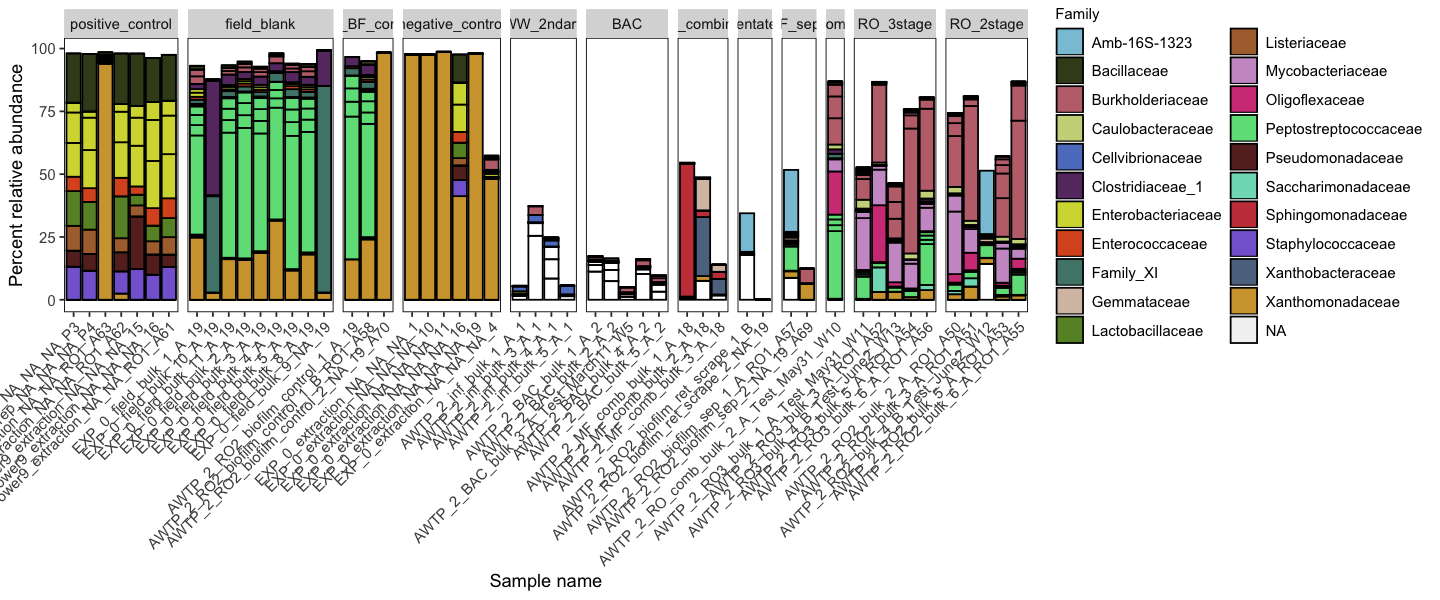

In [59]:
## Plot bar
options(repr.plot.width = 12, repr.plot.height = 5)
#playing with the colors a bit:
colors2 <- colors[-c(2,3,4)]
colors2[8] <- colors[2]

plot_bar(ps_dpwf_blank_perc_filt2, x="sample_code_full_and_batch", fill="Family") + scale_fill_manual(values = colors2) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~location_code, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))

#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/tax_barplot_min2perc.pdf", device="pdf", width=12, height=6)
                                                                                                

Warning message:
“Transformation introduced infinite values in discrete y-axis”

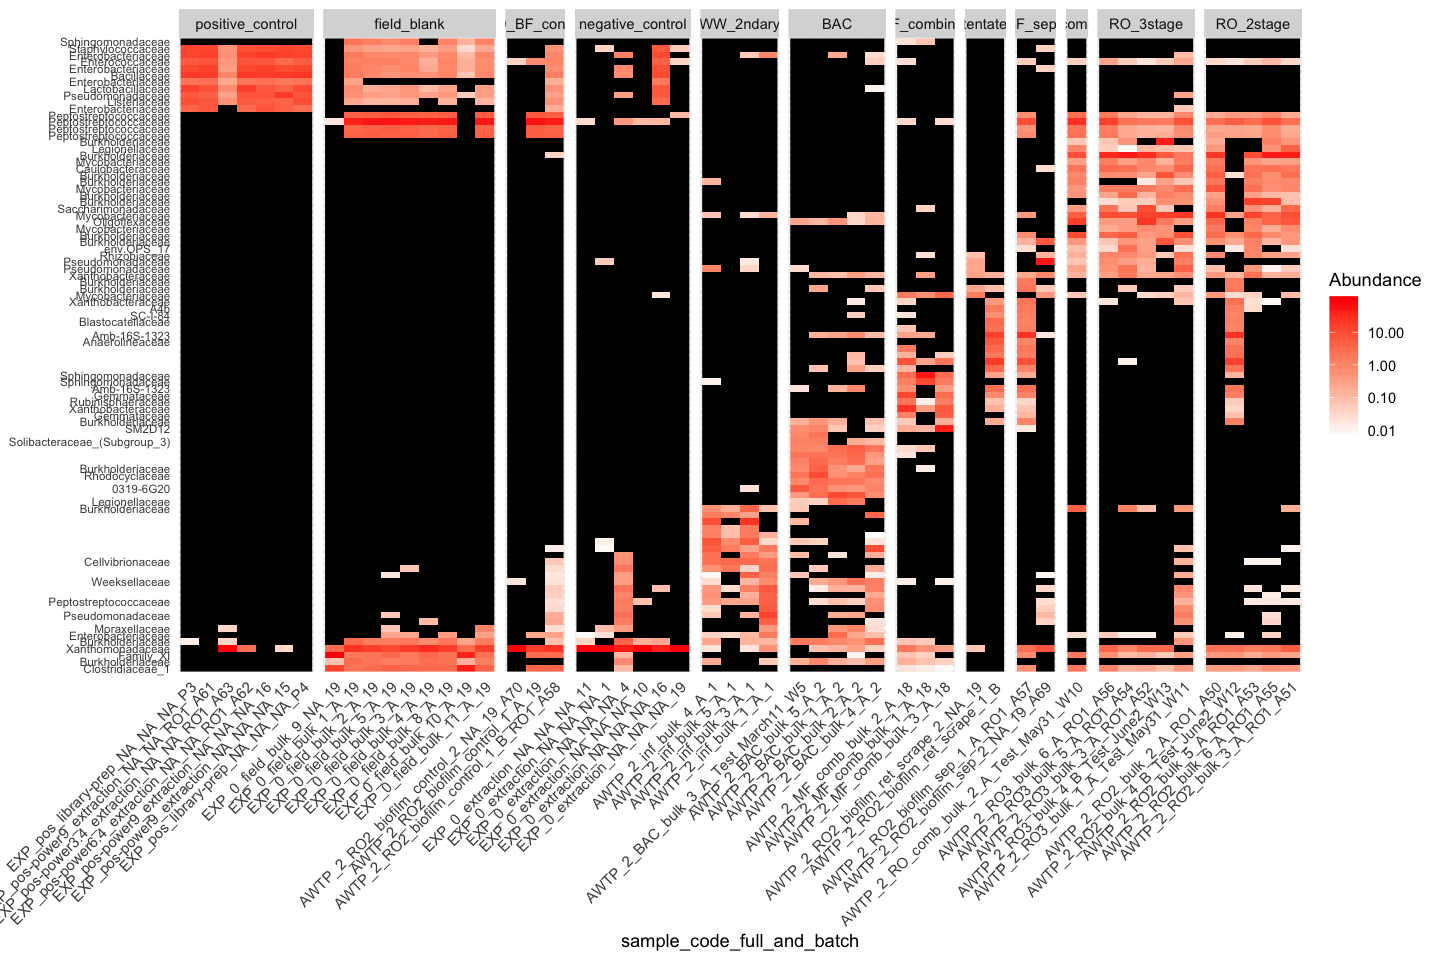

In [65]:
#plot heatmap
options(repr.plot.width = 12, repr.plot.height = 8)
plot_heatmap(ps_dpwf_blank_perc_filt1, taxa.label = "Family", sample.label = "sample_code_full_and_batch", sample.order = "location_code", method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")

#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/tax_heatmap_min2perc.pdf", device="pdf", width=8, height=6.5)

# Run DESeq to identify putative contaminants

In [96]:
#run DESeq2 on all bulk and blank ASVs together
#identify ASVs significantly more prevalent in bulk
#keep ASVs present only in bulk and ASVs significantly more prevalent in bulk than blank

## Preparing for DESeq

#select only samples of interest
ps_dpwf <- subset_samples(ps, subset = project_type %in% c("DPWF", "Experimental"))
ps_blank <- subset_samples(ps, subset = location_code %in% c("negative_control", "field_blank"))

#blanks_list <- c("Amplification_PlateX_na", "Amplification_PlateY_na", "Amplification_PlateP_na", 
#  "Extraction_PhenolChloroform_na", "Field_NA_184", "Field_NA_206", "Field_NA_213") #blanks that apply to bulk data

#ps_blank <- subset_samples(ps_blank, subset = longer_name %in% c(blanks_list))

#merge bulk and blank samples back together and filter for only taxa that occur in at least one sample
ps_dpwf_blank <- merge_phyloseq(ps_dpwf, ps_blank)
#remove samples with too few reads
ps_dpwf_blank <- prune_samples(sample_sums(ps_dpwf_blank)>=1000, ps_dpwf_blank) #remove failed samples
ps_dpwf_blank <- filter_taxa(ps_dpwf_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

In [97]:
ps_dpwf_blank

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4457 taxa and 52 samples ]
sample_data() Sample Data:       [ 52 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 4457 taxa by 6 taxonomic ranks ]

In [106]:
## Filter taxa occurring in samples and taxa occuring in blanks. 
#for later: Get bulk-only taxa and intersecting taxa.

ps_blank_occur <- filter_taxa(ps_blank, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0
ps_dpwf_occur <- filter_taxa(ps_dpwf, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

blank_taxa <- row.names(tax_table(ps_blank_occur))
dpwf_taxa <- row.names(tax_table(ps_dpwf_occur))
intersecting_taxa <- intersect(dpwf_taxa, blank_taxa)
dpwf_only_taxa <- setdiff(dpwf_taxa, intersecting_taxa)
blank_only_taxa <- setdiff(blank_taxa, intersecting_taxa)

ps_dpwf_only <- prune_taxa(dpwf_only_taxa, ps_dpwf_blank)

ps_dpwf_and_intersecting <- prune_taxa(c(intersecting_taxa, dpwf_only_taxa), ps_dpwf_blank)
ps_dpwf_and_intersecting <- filter_taxa(ps_dpwf_and_intersecting, filterfun(kOverA(1, 0)), TRUE) #where number of samples=1, min_reads>0

In [109]:
length(intersecting_taxa) + length(dpwf_only_taxa)
length(blank_taxa)

[1] 4457

[1] 322

In [111]:
unique(sample_data(ps_dpwf_blank)$project_type)

[1] Experimental DPWF        
Levels: DPWF Experimental

In [115]:
#run DESeq on the bulk and blank taxa
# solution to having zeros in the otu table found here: https://support.bioconductor.org/p/63229/
# review this solution again in the future!

diagddsraw = phyloseq_to_deseq2(ps_dpwf_blank, ~ project_type) # types are "Experimental" for controls and "DPWF" for samples
gm_mean = function(x, na.rm=TRUE){  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))}

geoMeans = apply(counts(diagddsraw), 1, gm_mean)
diagdds = estimateSizeFactors(diagddsraw, geoMeans = geoMeans)

dds = DESeq(diagdds, test="Wald", fitType="local")

#analyze results of DESeq filtering for significance
res = results(dds, cooksCutoff = FALSE)
alpha = 0.01
sigtab = res[which(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(ps_dpwf_blank)[rownames(sigtab), ], "matrix"))
sigtab
significant_taxa <- row.names(sigtab[sigtab$log2FoldChange < 0,]) #remove anything significantly enriched in blanks

converting counts to integer mode
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 1416 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
AGGGTCCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGTAGCGAACA,22.27444,-6.774404,1.5408016,-4.396675,1.099218e-05,7.123366e-05,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium
AGGGTCCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTTGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA,114.43347,-28.955075,2.0272714,-14.282782,2.801909e-46,2.315077e-44,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium
AGGGTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGCGTGCGTAGGTGGTTTGTTAAGTCTGATGTGAAAGCCCTGGGCTCAACCTGGGAATGGCATTGGAAACTGGCTTACTAGAGTGCGGTAGAGGGTAGCGGAATTCCCGGTGTAGCAGTGAAATGCGTAGATATCGGGAGGAACATCCGTGGCGAAGGCGGCTACCTGGACCAGCACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACA,6891.91257,4.548518,0.8735882,5.206707,1.922210e-07,1.337454e-06,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Lysobacter
AGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGCTTTGCAAGACAGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTTTGTGACTGCAAGGCTAGAGTACGGCAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGGCCTGTACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,2018.00213,-11.991831,2.2454567,-5.340487,9.269737e-08,6.518401e-07,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Aquabacterium
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATGTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAATGGCATTTGAGACTGCATGGCTAGAGTGTGTCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,67.41263,-28.235342,2.8695324,-9.839702,7.593566e-23,8.963119e-22,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Herminiimonas
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTGGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA,864.52200,-30.000000,1.4513611,-20.670253,6.417912e-95,4.242240e-92,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGAGGTGAAATCCCCGGGCTCAACCTGGGAACTGCCTCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTAGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACTACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACA,53.10111,-27.910295,1.7283261,-16.148743,1.158986e-58,1.276816e-56,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas
AGGGGGCTAGCGTTGCTCGGAATTACTGGGCGTAAAGGGAGCGTAGGCGGACTGTTTAGTCAGAGGTGAAAGCCCAGGGCTCAACCTTGGAATTGCCTTTGATACTGGCAGTCTTGAGTACGGAAGAGGTATGTGGAACTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGACATACTGGTCCGTTACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACA,30.85875,-6.825815,1.5180301,-4.496495,6.908265e-06,4.521152e-05,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Caulobacter
AGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGTGCGTAGGCGGGTCTTTAAGTCAGGGGTGAAATCCTGGAGCTCAACTCCAGAACTGCCTTTGATACTGAAGATCTTGAGTTCGGGAGAGGTGAGTGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTCACTGGCCCGATACTGACGCTGAGGCACGAAAGCGTGGGGAGCAAACA,60.45970,-9.481993,1.1561376,-8.201440,2.375249e-16,1.784136e-15,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Bradyrhizobium


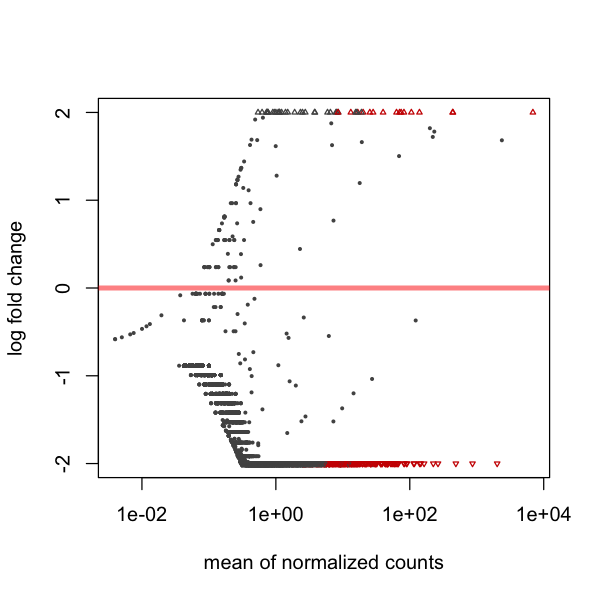

In [116]:
#plot deseq results
options(repr.plot.width = 5, repr.plot.height = 5)
plotMA(res, ylim=c(-2,2))

In [117]:
## Identify ASVs that were in both blank and samples and were significantly enriched in samples
samples_over_blanks <- intersect(intersecting_taxa, significant_taxa)

sigtab[row.names(sigtab) %in% samples_over_blanks,] #what are these taxa?



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Kingdom,Phylum,Class,Order,Family,Genus
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
AGGGTCCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGTAGCGAACA,22.27444,-6.774404,1.540802,-4.396675,1.099218e-05,7.123366e-05,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium
AGGGGGCTAGCGTTGCTCGGAATTACTGGGCGTAAAGGGAGCGTAGGCGGACTGTTTAGTCAGAGGTGAAAGCCCAGGGCTCAACCTTGGAATTGCCTTTGATACTGGCAGTCTTGAGTACGGAAGAGGTATGTGGAACTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGACATACTGGTCCGTTACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACA,30.85875,-6.825815,1.518030,-4.496495,6.908265e-06,4.521152e-05,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Caulobacter
AGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCGTTAAGTTGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTGGCGAGCTAGAGTACGGTAGAGGGTGGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACCACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACA,15.56114,-26.214405,2.347198,-11.168382,5.823194e-29,1.012929e-27,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas
AGGATGCGAGCGTTGTCCGGATTTATTGGGCGTAAAGAGTTCGTAGGTGGTTTGTTAAGTTTGATGTTAAAGATCGGGGCTCAACCTCGGGACAGCATTGAATACTGGCAGACTTGAGTATGGTAGAGGCTAGTGGAATTCCCAGTGTAGCGGTGAAATGCGTAGATATTGGGAAGAACACCGGTGGCGTAGGCGACTAGCTGGGCCATAACTGACGCTGAGGAACGAAAGCCAGGGGAGCGAAAG,16.25604,-6.617257,1.733353,-3.817606,1.347531e-04,8.324466e-04,Bacteria,Cyanobacteria,Melainabacteria,Obscuribacterales,NA,NA
AGGATCCAAGCGTTATCCGGAATTACTGGGCGTAAAGCGTGCGCAGACGGTTTGGTAGGTCTGGTGCGAAATCCGGTGGCTCAACCACCTGGACTGTACCAGAAACCCCCTGACTCGAGGTCGGTAGAGGCAAGTGGAATTGCTGGTGTAGGGGTGACATCCGTAGATATCAGCAGGAACACCAATGGCGAAGGCAGCTTGCTGGGCCGTACCTGACGTTCAGGCACGAAAGCGTGGGGAGCGAAC,83.41718,-8.331226,2.529407,-3.293747,9.886131e-04,5.585241e-03,Bacteria,NA,NA,NA,NA,NA
AGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCACGTTGTCCGTGAAAACTCACAGCTTAACTGTGGGCGTGCGGGCGATACGGGCAGACTGGAGTACTGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACA,51.68710,-8.807473,1.704290,-5.167825,2.368337e-07,1.613888e-06,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,Mycobacterium
AGGGTCCAAGCGTTATTCGGAATTACTGGGCGTAAAGCGTACGTAGGCGGTTTGGTAAGTTGGATGTGAAATCCTGTGGCTCAACCACATGGACTGTGTCCAAAACTACCAAACTTGAGCATAGTAGAGGCAAGTGGAATTTGCGGTGTAGGAGTGACATCCGTAGATATCGCAAGGAACACCAATGGCGAAGGCAGCTTGCTGGGCTATTGCTGACGCTCAGGTACGAAAGCGTGGGGAGCGAAC,90.70704,-6.106574,1.852848,-3.295777,9.815002e-04,5.585241e-03,Bacteria,Patescibacteria,Saccharimonadia,Saccharimonadales,NA,NA
AGGGGGCTAGCGTTATCCGGAATTACTGGGCGTAAAGGGTGCGTAGGTGGTTTCTTAAGTCAGAGGTGAAAGGCTACGGCTCAACCGTAGTAAGCCTTTGAAACTGGGAAACTTGAGTGCAGGAGAGGAGAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTTGCGAAGGCGGCTCTCTGGACTGTAACTGACACTGAGGCACGAAAGCGTGGGGAGCAAACAG,58.84154,-6.245129,1.728779,-3.612451,3.033166e-04,1.822657e-03,Bacteria,Firmicutes,Clostridia,Clostridiales,Peptostreptococcaceae,Romboutsia
AGACCACAAACGTTATCCGGAATCATTGGGCGTAAAGCGTACCGATAGGTGGTTTACTAAGCCAGAGGTGAAATCTCCGAGCCCAACTCGGAATCTGTCCTTTGGAACTGGTAAACTAGAGGGACAAAGAGGAAGCTGGAACAAACGGTGTAGTAGTGAAATGCGTTGATATCGTTTGGAACACCAATAGCGAAGGCTGGCTTCTGGGTGTCACCTGACACTGCTAGGACGAAAGCGTGGGGAGCG,45.02424,-27.681630,2.812864,-9.841082,7.490080e-23,8.963119e-22,Bacteria,Patescibacteria,Parcubacteria,Candidatus_Doudnabacteria,NA,NA


In [120]:
## Combine to get taxa from bulk-only and taxa significant by DESeq, convert to relative abundance of remaining reads
ps_dpwf_blank_sig <- prune_taxa(taxa=union(significant_taxa, dpwf_only_taxa), ps_dpwf_blank)
sample_data(ps_dpwf_blank_sig)$filtered_readcounts <- sample_sums(ps_dpwf_blank_sig)


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


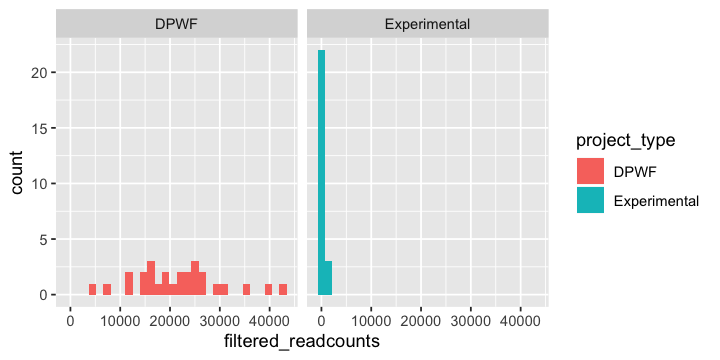

In [129]:
after_decontam <- as.data.frame(sample_data(ps_dpwf_blank_sig)[, c('filtered_readcounts', 'sample_code_full_and_batch', 'project_type')])

options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(after_decontam, aes(x=filtered_readcounts, fill=project_type))+
geom_histogram()+
facet_grid(~project_type)

In [136]:
min(after_decontam[after_decontam$project_type=='DPWF']$filtered_readcounts)
max(after_decontam[after_decontam$project_type=='Experimental']$filtered_readcounts)

[1] 4422

[1] 1170

In [176]:
ps_dpwf_blank_sig_pruned <- prune_samples(sample_sums(ps_dpwf_blank_sig)>=1200, ps_dpwf_blank_sig) #remove samples now with too few reads
ps_dpwf_blank_sig_perc <- transform_sample_counts(ps_dpwf_blank_sig_pruned, function(OTU) 100*OTU/sum(OTU))

ps_dpwf_blank_sig_pruned.1 <- prune_samples(sample_sums(ps_dpwf_blank_sig)>=1, ps_dpwf_blank_sig) #remove samples now with too few reads
ps_dpwf_blank_sig_perc.1 <- transform_sample_counts(ps_dpwf_blank_sig_pruned, function(OTU) 100*OTU/sum(OTU))
                                                  
ps_dpwf_blank_sig_perc

ps_dpwf_clean <- subset_samples(ps_dpwf_blank_sig_pruned, subset= project_type %in% "DPWF")
ps_dpwf_clean_perc <- transform_sample_counts(ps_dpwf_clean, function(OTU) 100*OTU/sum(OTU))
                                              
#saveRDS(ps_bulk_clean_perc, "/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/amplicon_data_deseq.rds")

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4144 taxa and 27 samples ]
sample_data() Sample Data:       [ 27 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 4144 taxa by 6 taxonomic ranks ]

In [173]:
sample_data(ps_dpwf_blank_sig_perc)

,id_full,count_raw_reads,barcode_forward,barcode_reverse,plate,well,metagenomic_sample,sample_code_full_and_batch,sample_date,batch_sample_date,⋯,sample_type,sampler_name,Ext_batch,Extraction_Date,Ext_num_unique,Microconcentrated.,DNA_Ext_conc_ngperuL,kit,id,filtered_readcounts
,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<dbl>
SD006,KNLK_SD006,30734,TACGAGAC,CATGAGGA,1,D5,Y,AWTP_2_RO2_biofilm_sep_1_A_RO1_A57,1/10/2018,NA,⋯,biofilm,Rose_Kantor,RO1,9/13/18,A57,Y,1.17,Powersoil Pro,SD006,16719
SD009,KNLK_SD009,60539,AGAGTCAC,AGTCTAGA,1,C6,Y,AWTP_2_MF_comb_bulk_2_A_18,11/14/2017,NA,⋯,DEUF,Scott_Miller,18,9/8/18,172,Y,1.91,PowerSoil Pro,SD009,35760
SD023,KNLK_SD023,29335,AGAGTCAC,TCACGATG,1,C10,Y,AWTP_2_BAC_bulk_3_A_Test_March11_W5,10/10/2017,NA,⋯,DEUF,Scott_Miller,Test_March11,3/11/18,W5,supernatant,27,NA,SD023,19080
SD024,KNLK_SD024,27139,TACGAGAC,TCACGATG,1,D10,Y,AWTP_2_RO2_biofilm_ret_scrape_2_NA_19,8/8/2018,NA,⋯,biofilm,Rose_Kantor,19,9/27/18,199,N,30.5,PowerSoil Pro,SD024,16785
SD028,KNLK_SD028,35200,CTACTATA,TAGACTGA,1,A11,Y,AWTP_2_BAC_bulk_5_A_2,12/14/2017,NA,⋯,DEUF,Scott_Miller,2,6/16/18,15,N,169,PowerSoil Pro,SD028,21424
SD030,KNLK_SD030,38480,AGAGTCAC,TAGACTGA,1,C11,Y,AWTP_2_inf_bulk_4_A_1,11/14/2017,NA,⋯,DEUF,Scott_Miller,1,6/15/18,4,N,518,PowerSoil Pro,SD030,20583
SD031,KNLK_SD031,37100,TACGAGAC,TAGACTGA,1,D11,Y,AWTP_2_inf_bulk_5_A_1,12/14/2017,NA,⋯,DEUF,Scott_Miller,1,6/15/18,5,N,542,PowerSoil Pro,SD031,4422
SD032,KNLK_SD032,23905,ACGTCTCG,TAGACTGA,1,E11,Y,AWTP_2_RO2_biofilm_ret_scrape_1_B,1/10/2018,NA,⋯,biofilm,Rose_Kantor,2,6/16/18,9,N,600,PowerSoil Pro,SD032,15107
SD033,KNLK_SD033,41694,TCGACGAG,TAGACTGA,1,F11,Y,AWTP_2_inf_bulk_3_A_1,10/10/2017,NA,⋯,DEUF,Scott_Miller,1,6/15/18,3,N,680,PowerSoil Pro,SD033,27142


# Community analysis

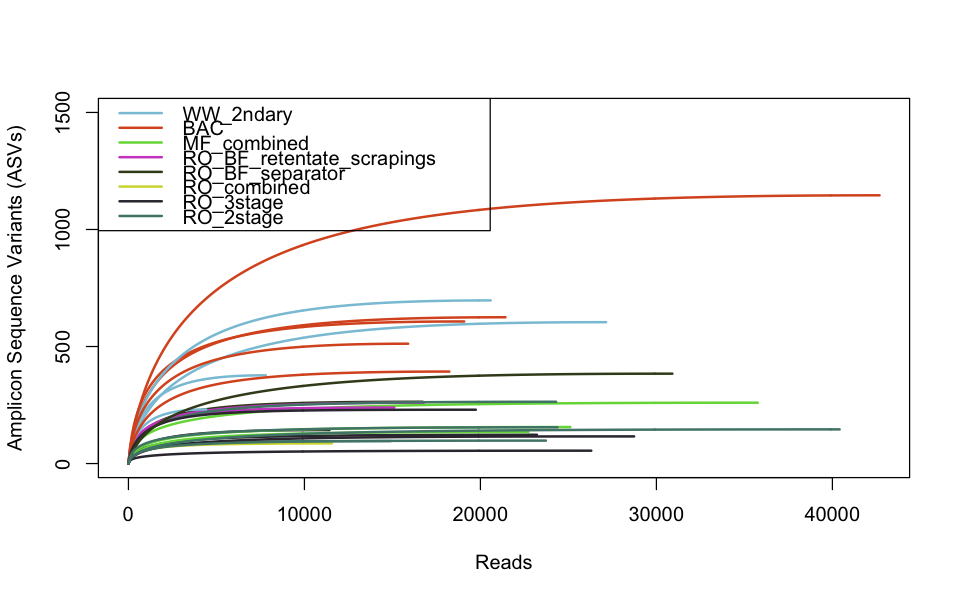

In [143]:
otu_bulk_clean <- as.data.frame(otu_table(ps_dpwf_clean))

bulk_locations_colors <- c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10], colors[11], colors[12])
palette(c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10], colors[11], colors[12]))

options(repr.plot.width = 8, repr.plot.height = 5)

#pdf("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/rarecurve_bulk_nolabels.pdf", height=6, width=8)
rarecurve(otu_bulk_clean, step=100, col=sample_data(ps_dpwf_blank_sig_pruned)$location_code, 
          xlab="Reads", ylab="Amplicon Sequence Variants (ASVs)", lwd=2, ylim=c(0,1500), label=FALSE)

legend("topleft", legend=c('WW_2ndary',
                           'BAC',
                           'MF_combined',
                           'RO_BF_retentate_scrapings',
                           'RO_BF_separator',
                           'RO_combined',
                           'RO_3stage',
                           'RO_2stage'), 
       col=bulk_locations_colors, 
       lty=1, lwd=2)


Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”

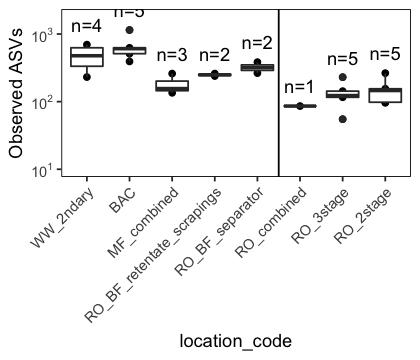

In [145]:
#define function to put sample count above data
n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}
options(repr.plot.width = 3.5, repr.plot.height = 3)
plot_richness(ps_dpwf_clean, x="location_code", measures=c("Observed"))+
    geom_boxplot()+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
     strip.background = element_blank(), 
     strip.text.x = element_blank(),
     #axis.title.x = element_blank(),
     axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    ylab("Observed ASVs") +
    scale_y_continuous(trans="log10", limits=c(10,1800), labels=trans_format("log10", math_format(10^.x)))+
    stat_summary(fun.data = n_fun, geom = "text", vjust=-1)+
    geom_vline(xintercept=5.5, linetype='solid')

#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/asv_observed_boxplot.svg", device="svg", width=3.5, height=2.75)

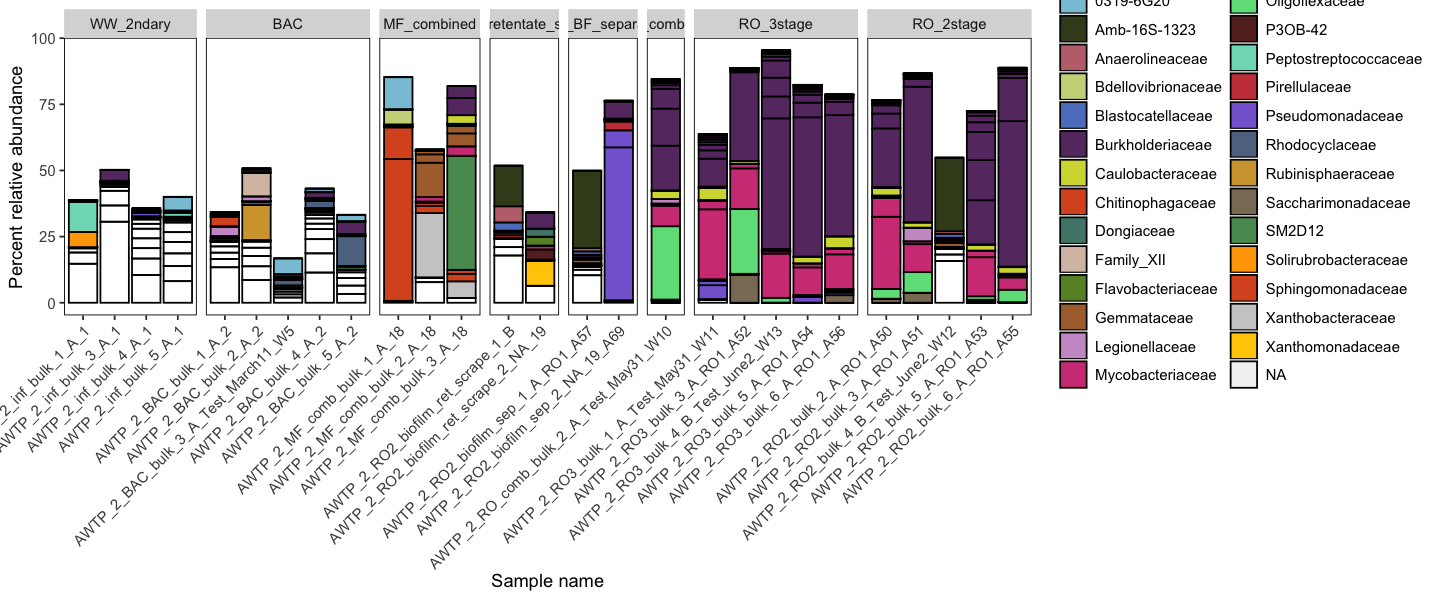

In [152]:
## Plot bar and heatmap
ps_bulk_blank_sig_perc_filt2 <- filter_taxa(ps_dpwf_blank_sig_perc, filterfun(kOverA(1, 2.9)), TRUE) #one sample, 2 perc.
options(repr.plot.width = 12, repr.plot.height = 5)
#playing with the colors a bit:
colors2 <- colors[-c(2,3,4)]
colors2[8] <- colors[2]

plot_bar(ps_bulk_blank_sig_perc_filt2, x="sample_code_full_and_batch", fill="Family") + scale_fill_manual(values = colors2) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~location_code, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))

#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/tax_barplot_min2perc.pdf", device="pdf", width=12, height=6)


Warning message:
“Transformation introduced infinite values in discrete y-axis”

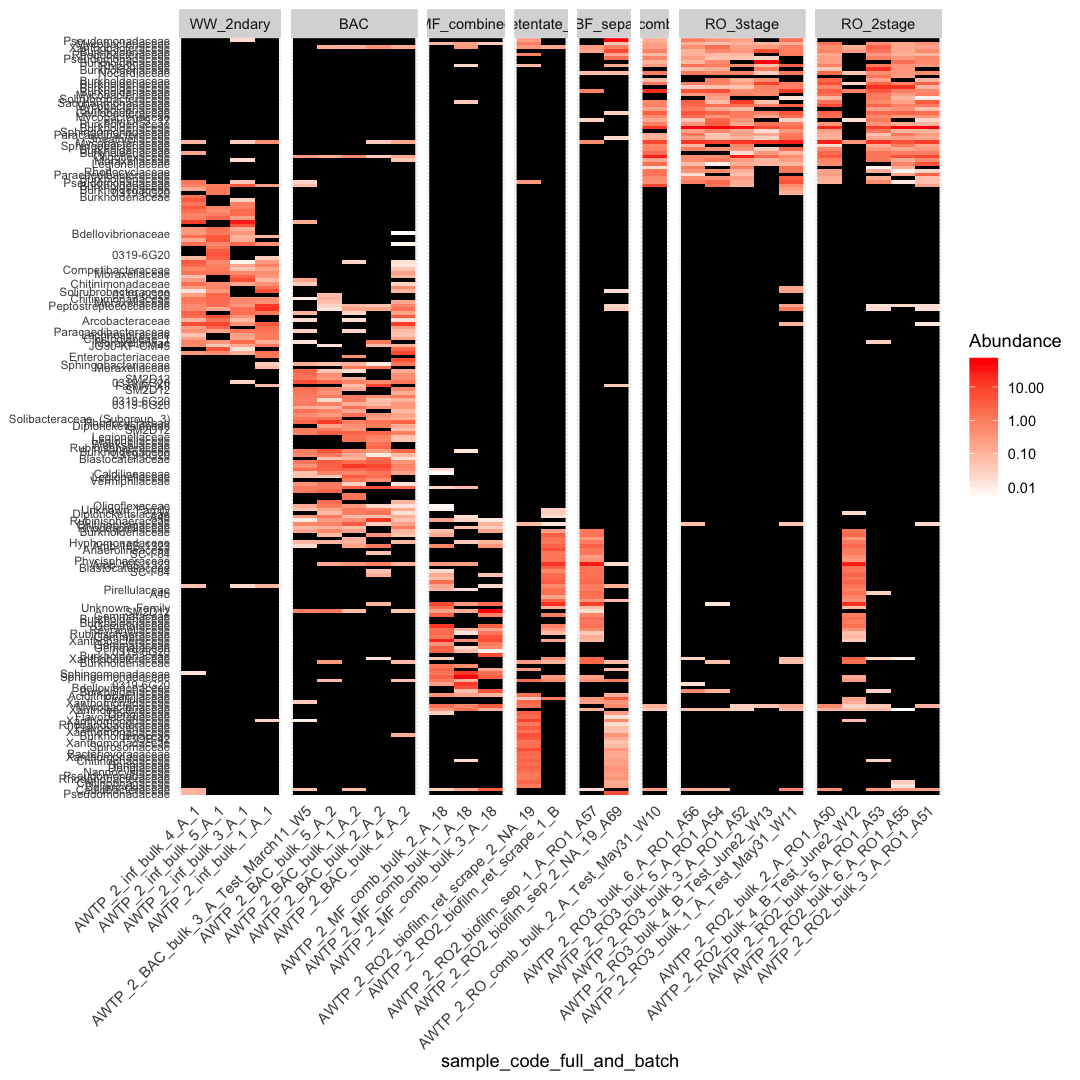

In [153]:
ps_bulk_blank_sig_perc_filt1 <- filter_taxa(ps_dpwf_blank_sig_perc, filterfun(kOverA(1, 1)), TRUE) #one sample, 2 perc.
                                                                                                
options(repr.plot.width = 9, repr.plot.height = 9)
plot_heatmap(ps_bulk_blank_sig_perc_filt1, taxa.label = "Family", sample.label = "sample_code_full_and_batch", sample.order = "location_code", method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")

#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/tax_heatmap_min2perc.pdf", device="pdf", width=8, height=6.5)

Warning message in metaMDS(veganifyOTU(physeq), distance, ...):
“stress is (nearly) zero: you may have insufficient data”Warning message:
“Transformation introduced infinite values in discrete y-axis”

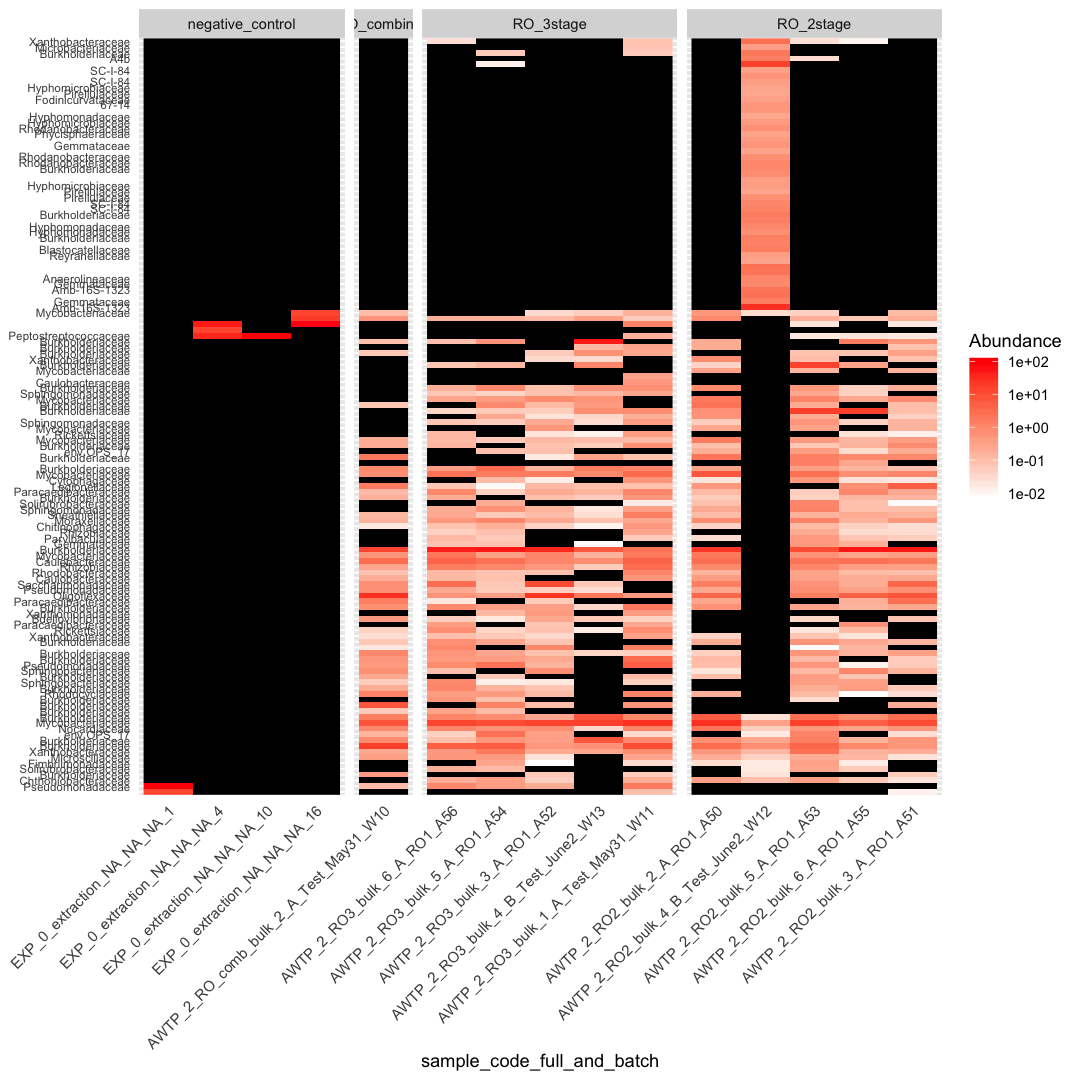

In [175]:
# RO only
# include negative controls that had more than 1 read after decontamination, else use ps_dpwf_blank_sig_perc

ps_ro_perc <- subset_samples(ps_dpwf_blank_sig_perc.1, subset = location_code %in% c('RO_3stage', 
                                                                                     'RO_2stage',
                                                                                     'RO_combined',
                                                                                     'negative_control'))
ps_ro_perc_filt.25 <- filter_taxa(ps_ro_perc, filterfun(kOverA(1, .25)), TRUE)
                                                                                                
options(repr.plot.width = 9, repr.plot.height = 9)
plot_heatmap(ps_ro_perc_filt.25, taxa.label = "Family", sample.label = "sample_code_full_and_batch", sample.order = "location_code", method="NMDS", 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")



## Look more closely at which extraction batches line up with which samples
Maybe the contaminants are only in a single extraction blank, but if they are in every sample from that extraction batch, that would suggest contamination

Warning message:
“Transformation introduced infinite values in discrete y-axis”

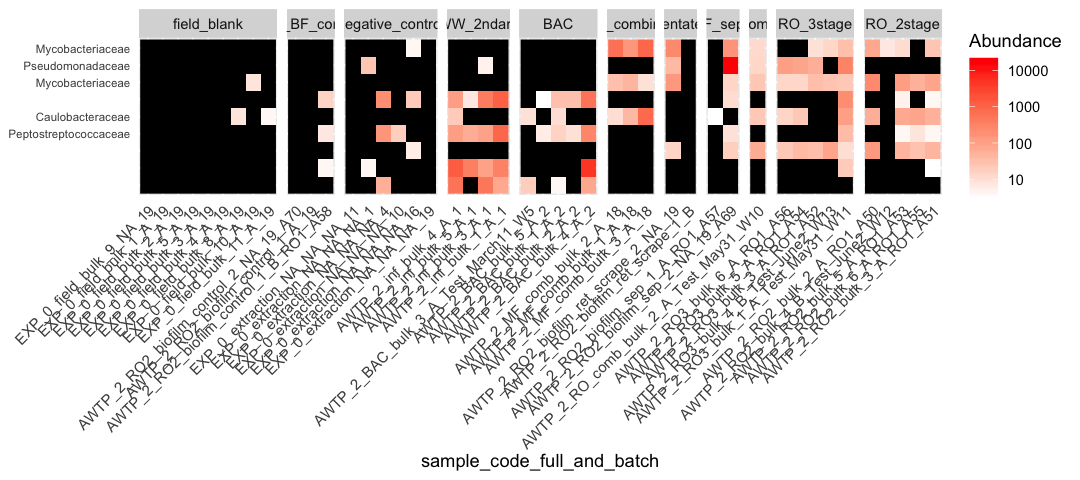

In [163]:
ps_samples_over_blanks <- prune_taxa(samples_over_blanks, ps_dpwf_blank)
ps_samples_over_blanks <- ps <- subset_samples(ps_samples_over_blanks,
                                               subset = !(location_code %in% c('positive_control')))
options(repr.plot.width = 9, repr.plot.height = 4)
plot_heatmap(ps_samples_over_blanks, taxa.label = "Family", sample.label = "sample_code_full_and_batch", sample.order = "location_code", method=NULL, 
        low="white", high="red", na.value="black", trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_code, scale="free_x", space="free_x")

#ggsave("/SCIENCE/Nelson_lab/write-ups/EPseq_paper/revised/figures/tax_heatmap_min2perc.pdf", device="pdf", width=8, height=6.5)

## ASVs present across treatment